In [37]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7.5)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
df_engagement = pd.read_csv('takehome_user_engagement.csv')
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df_users = pd.read_csv('takehome_users.csv', encoding='latin-1')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'])
df_engagement.drop(['visited'], axis=1, inplace=True)

In [7]:
grouped_users = pd.DataFrame(df_engagement.groupby('user_id')['time_stamp'].apply(list))
grouped_index = list(grouped_users.index)
grouped_timestamps = list(grouped_users['time_stamp'])

In [8]:
def is_adopted(timestamps):
    '''Takes in a list of datetimes and returns 1 if the user is adopted, 
    and 0 if the user is not adopted'''
    
    timestamps = pd.DataFrame(timestamps)
    timestamps[0] = pd.to_datetime(timestamps[0])
    timecounts = timestamps.set_index(0).sort_index().resample('1W').size()
    
    for i in timecounts:
        if i >= 3:
            return 1
    return 0

In [9]:
# weekly = df_engagement.set_index('time_stamp').sort_index().resample('1W').size()
adapted = list(map(is_adopted, grouped_timestamps))

In [10]:
df_adopted = pd.DataFrame({'object_id':grouped_index, 'adopted':adapted})
df_adopted.head()

,object_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [11]:
df_clean = pd.merge(df_users, df_adopted, on='object_id', how='outer')
df_clean.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [12]:
df_clean.drop(['email'], axis=1, inplace=True)
df_clean.head()

,object_id,creation_time,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       8823 non-null float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.0+ MB


In [14]:
convertor = lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
df_clean['last_session_creation_time'] = df_clean['last_session_creation_time'].map(convertor, na_action='ignore')
df_clean.head()

,object_id,creation_time,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0


In [22]:
df_clean['creation_time'] = pd.to_datetime(df_clean['creation_time'])
df_clean['last_session_creation_time'] = pd.to_datetime(df_clean['last_session_creation_time'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       8823 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 1.0+ MB


In [23]:
df_clean['activity_age'] = df_clean['last_session_creation_time'] - df_clean['creation_time']
df_clean['activity_age'] = df_clean['activity_age'] / np.timedelta64(1, 'D')
df_clean.head()

,object_id,creation_time,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,activity_age
0,1,2014-04-22 03:53:30,Clausen August,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0,5.0


In [26]:
df_clean_ml = df_clean.drop(['object_id', 'creation_time', 'name', 'last_session_creation_time'], axis=1)
df_clean_ml.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,activity_age
0,GUEST_INVITE,1,0,11,10803.0,0.0,0.0
1,ORG_INVITE,0,0,1,316.0,1.0,136.0
2,ORG_INVITE,0,0,94,1525.0,0.0,0.0
3,GUEST_INVITE,0,0,1,5151.0,0.0,1.0
4,GUEST_INVITE,0,0,193,5240.0,0.0,5.0


In [28]:
df_clean_ml = pd.get_dummies(df_clean_ml)
df_clean_ml.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,activity_age,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0.0,0.0,1,0,0,0,0
1,0,0,1,316.0,1.0,136.0,0,1,0,0,0
2,0,0,94,1525.0,0.0,0.0,0,1,0,0,0
3,0,0,1,5151.0,0.0,1.0,1,0,0,0,0
4,0,0,193,5240.0,0.0,5.0,1,0,0,0,0


In [31]:
df_clean_ml.fillna(0, inplace=True)
df_clean_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
adopted                               12000 non-null float64
activity_age                          12000 non-null float64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
dtypes: float64(3), int64(3), uint8(5)
memory usage: 1.0 MB


In [32]:
X = df_clean_ml.drop('adopted', axis=1)
y = df_clean_ml['adopted']
X.shape, y.shape

((12000, 10), (12000,))

In [33]:
def train_test_model(X, y, model, params, test_size=.2, random_state=32):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model_cv = GridSearchCV(model, param_grid=params, cv=5)
    
    model_cv.fit(X_train, y_train)
    
    y_pred = model_cv.predict(X_test)
    
    y_pred_prob = model_cv.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(model_cv.best_params_))
    print("Tuned Accuracy Score: {}".format(model_cv.best_score_))
    print(classification_report(y_test, y_pred))

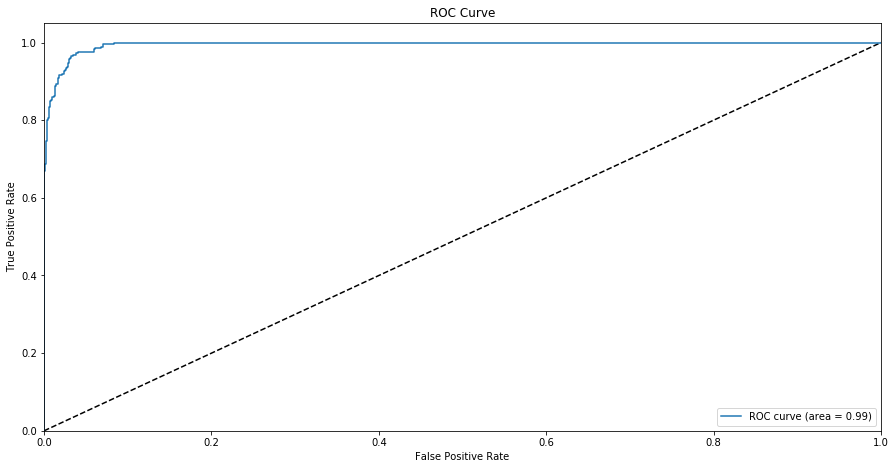

Tuned Hyperparameter(s): {'C': 0.2976351441631313, 'penalty': 'l1'}
Tuned Accuracy Score: 0.9786458333333333
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2116
         1.0       0.94      0.84      0.89       284

    accuracy                           0.97      2400
   macro avg       0.96      0.92      0.94      2400
weighted avg       0.97      0.97      0.97      2400



In [40]:
logreg = LogisticRegression()
c_space = np.logspace(-10, 8, 20) # Covers a WIDE range of possible C values
logreg_param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

train_test_model(X, y, logreg, logreg_param_grid)

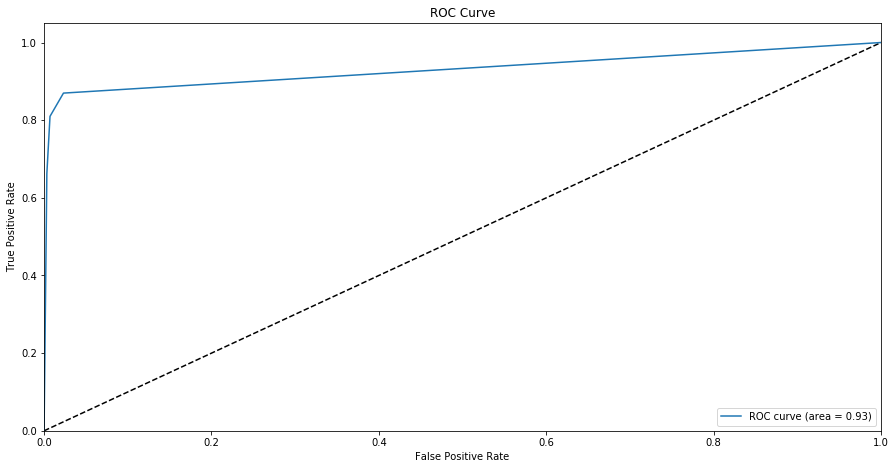

Tuned Hyperparameter(s): {'n_neighbors': 3}
Tuned Accuracy Score: 0.9722916666666667
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2116
         1.0       0.94      0.81      0.87       284

    accuracy                           0.97      2400
   macro avg       0.96      0.90      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [39]:
knn = KNeighborsClassifier()
N = [1,2,3,4,5,6,7]
knn_param_grid = {'n_neighbors': N}
train_test_model(X, y, knn, knn_param_grid)

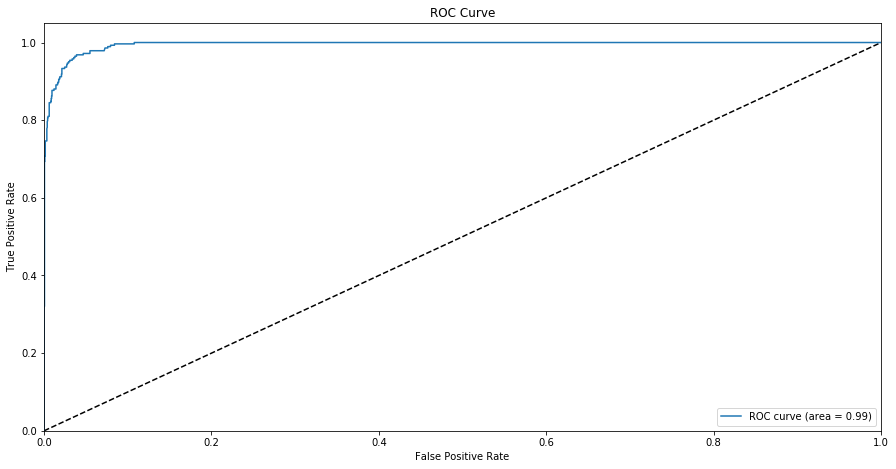

Tuned Hyperparameter(s): {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 70}
Tuned Accuracy Score: 0.9792708333333333
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2116
         1.0       0.91      0.88      0.89       284

    accuracy                           0.97      2400
   macro avg       0.95      0.93      0.94      2400
weighted avg       0.97      0.97      0.97      2400



In [38]:
forest = RandomForestClassifier()
forest_param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
train_test_model(X, y, forest, forest_param_grid)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=32)

best_model = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features=3, min_samples_split=250)
best_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=250,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [42]:
features = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
features

,importance
activity_age,0.982780
org_id,0.008428
creation_source_PERSONAL_PROJECTS,0.003768
invited_by_user_id,0.002489
creation_source_GUEST_INVITE,0.000903
opted_in_to_mailing_list,0.000378
creation_source_ORG_INVITE,0.000358
enabled_for_marketing_drip,0.000326
creation_source_SIGNUP,0.000299
creation_source_SIGNUP_GOOGLE_AUTH,0.000271


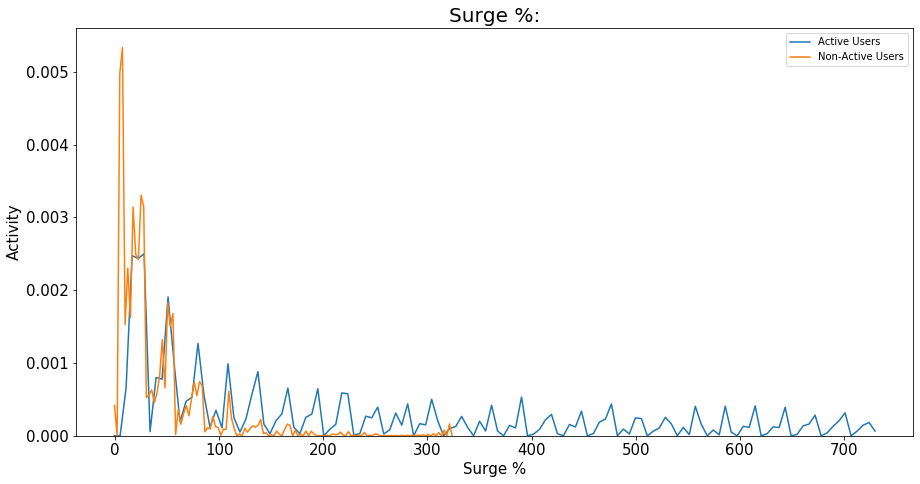

In [45]:
non_active = df_clean_ml[df_clean_ml['adopted'] == 0]

sns.distplot(df_clean_ml['activity_age'], hist=False, kde_kws={"label": "Active Users"});
sns.distplot(non_active['activity_age'], hist=False, kde_kws={"label": "Non-Active Users"});
plt.title('Surge %:', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Surge %", size=15)
plt.ylabel('Activity', size=15)
plt.show()